In [24]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [26]:
!cp /content/drive/MyDrive/Kaggle_credentials/kaggle.json ~/.kaggle/kaggle.json

In [27]:
! chmod 600 ~/.kaggle/kaggle.json

In [28]:
!pip install wandb -qU

In [29]:
# ! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

In [30]:
# ! unzip /content/walmart-recruiting-store-sales-forecasting.zip
# ! unzip /content/train.csv.zip
# ! unzip /content/test.csv.zip
# ! unzip /content/features.csv.zip
# ! unzip /content/sampleSubmission.csv.zip

In [31]:
import pandas as pd
import numpy as np
import wandb
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=== WALMART SALES FORECASTING - MODEL INFERENCE ===\n")

=== WALMART SALES FORECASTING - MODEL INFERENCE ===



In [32]:
# Initialize wandb for inference
wandb.login()
wandb.init(project="walmart-sales-forecasting", name="XGBoost_Inference", tags=["inference", "xgboost", "submission"])

print("Loading test datasets...")

# Load all necessary datasets
test = pd.read_csv("/content/test.csv")
features = pd.read_csv("/content/features.csv")
stores = pd.read_csv("/content/stores.csv")
sample_submission = pd.read_csv("/content/sampleSubmission.csv")

print(f"Test data shape: {test.shape}")
print(f"Features data shape: {features.shape}")
print(f"Stores data shape: {stores.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Log basic info
wandb.log({
    "test_samples": test.shape[0],
    "submission_samples": sample_submission.shape[0]
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loaded_model_mae,▁
loaded_model_r2,▁
loaded_model_rmse,▁
merged_test_shape,▁
model_features,▁
submission_samples,▁
test_missing_values,▁
test_samples,▁
loaded_model_mae,2829.07334
loaded_model_r2,0.95249
loaded_model_rmse,4950.42986


Loading test datasets...
Test data shape: (115064, 4)
Features data shape: (8190, 12)
Stores data shape: (45, 3)
Sample submission shape: (115064, 2)


In [33]:
# Merge test data with features and stores (same as training process)
print("\nMerging test datasets...")

test_data = test.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
test_data = test_data.merge(stores, on='Store', how='left')

print(f"Merged test data shape: {test_data.shape}")
print(f"Missing values in test data:\n{test_data.isnull().sum().sum()} total missing values")

# Check date range
test_data['Date'] = pd.to_datetime(test_data['Date'])
print(f"Test date range: {test_data['Date'].min()} to {test_data['Date'].max()}")

wandb.log({
    "merged_test_shape": test_data.shape[0],
    "test_missing_values": test_data.isnull().sum().sum(),
    "test_date_range_start": str(test_data['Date'].min()),
    "test_date_range_end": str(test_data['Date'].max())
})


Merging test datasets...
Merged test data shape: (115064, 15)
Missing values in test data:
127817 total missing values
Test date range: 2012-11-02 00:00:00 to 2013-07-26 00:00:00


In [34]:
# Download the best model from wandb
print("\n=== DOWNLOADING MODEL FROM WANDB ===")

try:
    # Get the latest version of the model artifact
    api = wandb.Api()
    artifact = api.artifact('walmart-sales-forecasting/xgboost_pipeline:latest', type='model')
    artifact_dir = artifact.download()

    print(f"✓ Model artifact downloaded to: {artifact_dir}")

    # Display model metadata
    model_metadata = artifact.metadata
    print(f"\nModel Information:")
    print(f"  Training MAE: {model_metadata.get('train_mae', 'N/A')}")
    print(f"  Training RMSE: {model_metadata.get('train_rmse', 'N/A')}")
    print(f"  Training MAPE: {model_metadata.get('train_mape', 'N/A')}%")
    print(f"  Training R²: {model_metadata.get('train_r2', 'N/A')}")
    print(f"  Features count: {model_metadata.get('features_count', 'N/A')}")
    print(f"  Training samples: {model_metadata.get('training_samples', 'N/A')}")

    # Log model metadata
    wandb.log({
        "loaded_model_mae": model_metadata.get('train_mae', 0),
        "loaded_model_rmse": model_metadata.get('train_rmse', 0),
        "loaded_model_r2": model_metadata.get('train_r2', 0),
        "model_features": model_metadata.get('features_count', 0)
    })

except Exception as e:
    print(f"❌ Error downloading model: {e}")
    print("Please check your wandb project and model artifact name")
    raise


=== DOWNLOADING MODEL FROM WANDB ===


wandb:   1 of 1 files downloaded.  


✓ Model artifact downloaded to: /content/artifacts/xgboost_pipeline:v2

Model Information:
  Training MAE: 2829.0733395522316
  Training RMSE: 4950.429855810212
  Training MAPE: 4941.608704966984%
  Training R²: 0.9524875616202894
  Features count: 34
  Training samples: 421570


In [35]:
# Download and load model from wandb (similar to MLflow model registry)
print("\n=== LOADING MODEL FROM WANDB ===")

with wandb.init(project="walmart-sales-forecasting", name="Load_Best_Model", tags=["inference", "model_loading"]) as run:

    # Download the model artifact (like MLflow model registry)
    model_artifact_name = "xgboost_pipeline:latest"
    print(f"Loading model: {model_artifact_name}")

    try:
        # Download artifact
        artifact = run.use_artifact(model_artifact_name, type='model')
        artifact_dir = artifact.download()

        # Find the pipeline file
        import os
        pipeline_files = [f for f in os.listdir(artifact_dir) if f.endswith('.pkl')]
        if not pipeline_files:
            raise FileNotFoundError("No pipeline file found in artifact")

        pipeline_path = os.path.join(artifact_dir, pipeline_files[0])

        # Load using cloudpickle (handles custom classes better) or dill
        try:
            import cloudpickle
            with open(pipeline_path, 'rb') as f:
                model_pipeline = cloudpickle.load(f)
            print("✓ Model loaded with cloudpickle")
        except ImportError:
            try:
                import dill
                with open(pipeline_path, 'rb') as f:
                    model_pipeline = dill.load(f)
                print("✓ Model loaded with dill")
            except ImportError:
                # Install cloudpickle and retry
                import subprocess
                subprocess.check_call(['pip', 'install', 'cloudpickle'])
                import cloudpickle
                with open(pipeline_path, 'rb') as f:
                    model_pipeline = cloudpickle.load(f)
                print("✓ Model loaded with cloudpickle (after install)")

        # Log model metadata
        wandb.log({
            "model_name": model_artifact_name,
            "model_loaded": True,
            "pipeline_components": list(model_pipeline.named_steps.keys())
        })

        print(f"✓ Model loaded successfully from wandb!")
        print(f"Pipeline components: {list(model_pipeline.named_steps.keys())}")

    except Exception as e:
        print(f"❌ Error loading from wandb: {e}")
        raise


=== LOADING MODEL FROM WANDB ===


loaded_model_mae,▁
loaded_model_r2,▁
loaded_model_rmse,▁
merged_test_shape,▁
model_features,▁
submission_samples,▁
test_missing_values,▁
test_samples,▁
loaded_model_mae,2829.07334
loaded_model_r2,0.95249
loaded_model_rmse,4950.42986


Loading model: xgboost_pipeline:latest


wandb:   1 of 1 files downloaded.  


✓ Model loaded with cloudpickle
✓ Model loaded successfully from wandb!
Pipeline components: ['preprocessor', 'model']


model_loaded,True
model_name,xgboost_pipeline:lat...


In [37]:
# Make predictions
print("\n=== MAKING PREDICTIONS ===")

# Initialize wandb run for predictions (if not already active)
if not wandb.run:
    wandb.init(project="walmart-sales-forecasting", name="XGBoost_Predictions", tags=["predictions", "inference"])

# Prepare test features (exclude target column that doesn't exist in test)
print("Preparing test features...")
X_test = test_data.copy()

print(f"Test features shape: {X_test.shape}")
print(f"Test feature columns: {list(X_test.columns)}")

# Make predictions using the pipeline
print("Making predictions...")
test_predictions = model_pipeline.predict(X_test)

print(f"✓ Predictions completed!")
print(f"Predictions shape: {test_predictions.shape}")
print(f"Predictions summary:")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")

# Log prediction statistics
wandb.log({
    "predictions_count": len(test_predictions),
    "predictions_min": float(test_predictions.min()),
    "predictions_max": float(test_predictions.max()),
    "predictions_mean": float(test_predictions.mean()),
    "predictions_std": float(test_predictions.std())
})


=== MAKING PREDICTIONS ===


Preparing test features...
Test features shape: (115064, 15)
Test feature columns: ['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']
Making predictions...
Transforming data with shape: (115064, 15)
Processed data shape: (115064, 34)
✓ Predictions completed!
Predictions shape: (115064,)
Predictions summary:
  Min: -5529.03
  Max: 313658.53
  Mean: 16204.65
  Std: 21527.74


In [38]:
# Create submission file
print("\n=== CREATING SUBMISSION FILE ===")

# Create submission DataFrame
submission = sample_submission.copy()
submission['Weekly_Sales'] = test_predictions

# Verify submission format
print(f"Submission shape: {submission.shape}")
print(f"Submission columns: {list(submission.columns)}")
print("\nFirst 10 predictions:")
print(submission.head(10))

print("\nLast 10 predictions:")
print(submission.tail(10))

# Check for any issues
if submission.isnull().sum().sum() > 0:
    print(f"⚠️  Warning: {submission.isnull().sum().sum()} missing values in submission")
else:
    print("✓ No missing values in submission")

if len(submission) != len(sample_submission):
    print(f"⚠️  Warning: Submission length mismatch!")
    print(f"Expected: {len(sample_submission)}, Got: {len(submission)}")
else:
    print("✓ Submission length matches expected format")


=== CREATING SUBMISSION FILE ===
Submission shape: (115064, 2)
Submission columns: ['Id', 'Weekly_Sales']

First 10 predictions:
               Id  Weekly_Sales
0  1_1_2012-11-02  33772.171875
1  1_1_2012-11-09  24450.027344
2  1_1_2012-11-16  21421.900391
3  1_1_2012-11-23  18479.703125
4  1_1_2012-11-30  26164.521484
5  1_1_2012-12-07  26219.849609
6  1_1_2012-12-14  38450.820312
7  1_1_2012-12-21  48503.582031
8  1_1_2012-12-28  25976.216797
9  1_1_2013-01-04  16512.126953

Last 10 predictions:
                      Id  Weekly_Sales
115054  45_98_2013-05-24    950.977783
115055  45_98_2013-05-31   1362.476318
115056  45_98_2013-06-07   1016.046997
115057  45_98_2013-06-14    919.172424
115058  45_98_2013-06-21    930.031311
115059  45_98_2013-06-28    794.476196
115060  45_98_2013-07-05    926.843262
115061  45_98_2013-07-12    729.958618
115062  45_98_2013-07-19    783.009644
115063  45_98_2013-07-26   1439.979370
✓ No missing values in submission
✓ Submission length matches expec


=== SAVING SUBMISSION ===
✓ Submission saved as: xgboost_submission_20250704_165728.csv

Submission Statistics:
  Total predictions: 115,064
  Average prediction: $16,204.65
  Prediction range: $-5,529.03 - $313,658.53


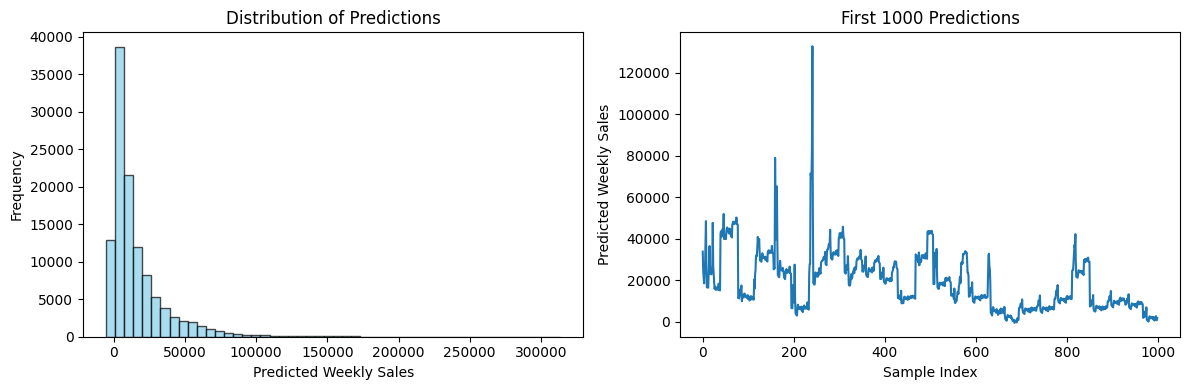

In [39]:
# Save submission file
print("\n=== SAVING SUBMISSION ===")

# Create timestamped filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
submission_filename = f"xgboost_submission_{timestamp}.csv"

# Save submission
submission.to_csv(submission_filename, index=False)
print(f"✓ Submission saved as: {submission_filename}")

# Display submission statistics
print(f"\nSubmission Statistics:")
print(f"  Total predictions: {len(submission):,}")
print(f"  Average prediction: ${submission['Weekly_Sales'].mean():,.2f}")
print(f"  Prediction range: ${submission['Weekly_Sales'].min():,.2f} - ${submission['Weekly_Sales'].max():,.2f}")

# Create simple visualization of predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')

plt.subplot(1, 2, 2)
plt.plot(test_predictions[:1000])  # Plot first 1000 predictions
plt.xlabel('Sample Index')
plt.ylabel('Predicted Weekly Sales')
plt.title('First 1000 Predictions')

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
wandb.log({"prediction_analysis": wandb.Image('prediction_analysis.png')})
plt.show()

In [40]:
# Log submission as wandb artifact
print("\n=== LOGGING SUBMISSION TO WANDB ===")

try:
    # Create submission artifact
    submission_artifact = wandb.Artifact(
        name=f"submission_{timestamp}",
        type="submission",
        description=f"XGBoost submission for Walmart sales forecasting - {timestamp}",
        metadata={
            "submission_count": len(submission),
            "predictions_mean": float(submission['Weekly_Sales'].mean()),
            "predictions_std": float(submission['Weekly_Sales'].std()),
            "predictions_min": float(submission['Weekly_Sales'].min()),
            "predictions_max": float(submission['Weekly_Sales'].max()),
            "model_used": "XGBoost Pipeline",
            "timestamp": timestamp
        }
    )

    # Add submission file to artifact
    submission_artifact.add_file(submission_filename)

    # Log artifact
    wandb.log_artifact(submission_artifact)
    print("✓ Submission logged to wandb successfully!")

except Exception as e:
    print(f"⚠️  Error logging submission to wandb: {e}")
    print("Submission file saved locally")

# Final log
wandb.log({
    "submission_filename": submission_filename,
    "inference_completed": True,
    "final_submission_count": len(submission)
})


=== LOGGING SUBMISSION TO WANDB ===
✓ Submission logged to wandb successfully!


In [41]:
# Final summary and instructions
print(f"\n" + "="*70)
print("INFERENCE COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"📁 Submission file: {submission_filename}")
print(f"📊 Total predictions: {len(submission):,}")
print(f"💰 Average prediction: ${submission['Weekly_Sales'].mean():,.2f}")
print(f"📈 Prediction range: ${submission['Weekly_Sales'].min():,.2f} - ${submission['Weekly_Sales'].max():,.2f}")
print(f"🤖 Model used: XGBoost Pipeline")
print(f"⏰ Generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)
print("📤 NEXT STEPS:")
print(f"1. Upload '{submission_filename}' to Kaggle competition")
print("2. Check your score on the leaderboard")
print("3. Compare with other models")
print("="*70)

wandb.finish()


INFERENCE COMPLETED SUCCESSFULLY!
📁 Submission file: xgboost_submission_20250704_165728.csv
📊 Total predictions: 115,064
💰 Average prediction: $16,204.65
📈 Prediction range: $-5,529.03 - $313,658.53
🤖 Model used: XGBoost Pipeline
⏰ Generated at: 2025-07-04 16:57:42
📤 NEXT STEPS:
1. Upload 'xgboost_submission_20250704_165728.csv' to Kaggle competition
2. Check your score on the leaderboard
3. Compare with other models


final_submission_count,▁
predictions_count,▁
predictions_max,▁
predictions_mean,▁
predictions_min,▁
predictions_std,▁
final_submission_count,115064
inference_completed,True
predictions_count,115064
predictions_max,313658.53125
predictions_mean,16204.65039
